In [156]:
"""
1. data_pipeline
    1.1 data_check
    1.2 data_get
    1.3 data_preprocessing
    1.4 raw_data to dataframe -> csv

2. 
"""

'\n1. data_pipeline\n    1.1 data_check\n    1.2 data_get\n    1.3 data_preprocessing\n    1.4 raw_data to dataframe -> csv\n\n2. \n'

In [157]:
import os 
from glob import glob
import json
import matplotlib.pyplot as plt
plt.rc('font',family='AppleGothic')

import pandas as pd
import seaborn as sns

from data_related.check_data import *
from data_related.get_data import get_data
from data_related.preprocess import *

In [158]:
### inputs ###
st_name = '선릉역'
st_line = '2호선'
st_direct = '하행선'

In [159]:
mapper = pd.read_csv('raw_data/StationCode_mapper.csv',index_col=0)
metro_df = pd.read_csv('metro_graph/metro_graph.csv',index_col=0)

In [160]:
# find next station
if st_direct == '상행선':
    st_name_next=metro_df[(metro_df['from']==st_name) & (metro_df['st_line']==st_line)]['to'].values[0]
elif st_direct == '하행선':
    st_name_next=metro_df[(metro_df['to']==st_name) & (metro_df['st_line']==st_line)]['from'].values[0]
else: 
    print('something wrong in metro direction')

In [161]:
# find st_code
st_code=mapper[(mapper['subwayLine']==st_line) & \
               (mapper['stationName']==st_name)]['stationCode'].values[0]

st_code_next=mapper[(mapper['subwayLine']==st_line) & \
            (mapper['stationName']==st_name_next)]['stationCode'].values[0]

### 1.1 Data_Check

In [162]:
# check raw_data
print('==raw_data==')
raw_data_available=check_raw_data(st_code)
print('\n==raw_data_next==')
raw_data_next_available=check_raw_data(st_code_next)

==raw_data==
congest_data => 56
congest_sectional_paths => 56
drop_off_paths => 56

==raw_data_next==
congest_data => 56
congest_sectional_paths => 56
drop_off_paths => 56


In [163]:
# check Integrated_data
print('==Integrated_data==')
Integrated_data_available=check_Integrated_data(st_code)
print('\n==Integrated_data_next==')
Integrated_data_next_available=check_Integrated_data(st_code_next)

==Integrated_data==
Integrated_data available

==Integrated_data_next==
Integrated_data available


In [164]:
stationname_li = [st_name,st_name_next]
dow_list=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']
hh_li = [str(i).zfill(2) for i in range(6,10)] + [str(i).zfill(2) for i in range(16,20)]

# st_name, st_code mapper
mapper=pd.read_csv('raw_data/StationCode_mapper.csv',index_col=0)

# check data
count = 0
need_to_get = list()
for stationname in stationname_li:
    for dow in dow_list:
        for hh in hh_li:
            station_code=mapper[(mapper['subwayLine']==st_line) & (mapper['stationName']==stationname)]['stationCode'].values[0]
            if len(glob(f'raw_data/??_{station_code}_{dow}_{hh}.json')) ==0:
                # print(f'{stationname}_{dow}_{hh}')
                need_to_get.append((stationname,dow,hh))
                count += 1
print(f'{count*3}번 api 호출')

# find only data doenst exist

stationname_li = list(set([i[0] for i in need_to_get]))
dow_li=list(set([i[1] for i in need_to_get]))
hh_li = list(set([i[2] for i in need_to_get]))

print(sorted(stationname_li))
print(sorted(dow_li))
print(sorted(hh_li))

0번 api 호출
[]
[]
[]


### 1.2 Data_Get

In [165]:
# get data
cnt = 0
for dow in dow_list:
        for hh in hh_li:
            get_data(st_code_next,dow,hh)
            cnt += 1

print(f'{cnt*3}번 api 호출')

0번 api 호출


### 1.3 Data_Preprocessing
#### 1.4 raw_data to dataframe -> csv

In [166]:
path_df=pd.DataFrame(glob('raw_data/*.json'),columns=['path'])
path_df=pd.concat([path_df,
                   path_df['path'].apply(lambda x : [x.split('/')[1][:2], x.split('/')[1][3:6]]).apply(pd.Series).rename(columns={0:'type',1:'sc'})], axis=1)

Integrated_data_list=glob('Intergrated_data/*.csv')

In [167]:
# 1. congest data to df
path_df_1=path_df[path_df['type']=='01']

for sc in path_df_1['sc'].unique():
    tmp=path_df_1[path_df_1['sc']==sc]
    tmp_list = list()
    # station_code base data_checker
    tmp_df_info = '_'.join(mapper[mapper['stationCode']==sc].values[0][:-1])
    # if there is data -> pass
    if len([i for i in Integrated_data_list if '01_'+tmp_df_info in i]) != 0:
        continue
    for path in tmp['path']:
        tmp_list.append(json2df(path))
    tmp_df = pd.concat(tmp_list)
    # if congestionTrain == 0 -> not evaluated so drop
    tmp_df=tmp_df[tmp_df['congestionTrain']!=0]
    tmp_df.to_csv(f'Intergrated_data/01_{tmp_df_info}.csv')

In [168]:
# 2. congest_sectional data to df
path_df_2=path_df[path_df['type']=='02']

for sc in path_df_2['sc'].unique():
    tmp=path_df_2[path_df_2['sc']==sc]
    tmp_list = list()
    tmp_df_info = '_'.join(mapper[mapper['stationCode']==sc].values[0][:-1])

    # if there is data -> pass
    if len([i for i in Integrated_data_list if '02_'+tmp_df_info in i]) != 0:
        continue    
    for path in tmp['path']:
        tmp_list.append(json2df(path))
    tmp_df = pd.concat(tmp_list)
#     # if congestionTrain == 0 -> not evaluated so drop
    tmp_df['congestionCar']=tmp_df['congestionCar'].apply(lambda x : x if 0 not in x else None)
    tmp_df.dropna(inplace=True)
    tmp_df_info = '_'.join(mapper[mapper['stationCode']==sc].values[0][:-1])
    tmp_df.to_csv(f'Intergrated_data/02_{tmp_df_info}.csv')

In [169]:
# 3. drop_off data to df
path_df_3=path_df[path_df['type']=='03']

for sc in path_df_3['sc'].unique():
    tmp=path_df_3[path_df_3['sc']==sc]
    tmp_list = list()
    tmp_df_info = '_'.join(mapper[mapper['stationCode']==sc].values[0][:-1])

    # if there is data -> pass
    if len([i for i in Integrated_data_list if '03_'+tmp_df_info in i]) != 0:
        continue    
    for path in tmp['path']:
        tmp_list.append(json2df(path))
    tmp_df = pd.concat(tmp_list)
#     # if congestionTrain == 0 -> not evaluated so drop
    tmp_df['getOffCarRate']=tmp_df['getOffCarRate'].apply(lambda x : x if 0 not in x else None)
    tmp_df.dropna(inplace=True)
    tmp_df.to_csv(f'Intergrated_data/03_{tmp_df_info}.csv')

In [170]:
path_1=sorted(glob(f'Intergrated_data/??_{st_line}_{st_name}*.csv'))
path_2=sorted(glob(f'Intergrated_data/??_{st_line}_{st_name_next}*.csv'))

In [171]:
df_1_raw=pd.read_csv(path_1[0],index_col=0)
df_1_next_raw=pd.read_csv(path_2[0],index_col=0)

df_2_raw=pd.read_csv(path_1[1],index_col=0)
df_2_next_raw=pd.read_csv(path_2[1],index_col=0)

df_3_raw=pd.read_csv(path_1[2],index_col=0)
df_3_next_raw=pd.read_csv(path_2[2],index_col=0)

In [172]:
df_1_using_cols=['subwayLine', 'stationName','statStartDate',
                 'statEndDate','prevStationCode', 'prevStationName', 'updnLine',
                 'directAt', 'dow', 'hh', 'mm', 'congestionTrain']

df_2_using_cols=['subwayLine', 'stationName', 'statStartDate',
                 'statEndDate', 'prevStationCode', 'prevStationName', 'updnLine',
                 'directAt', 'dow', 'hh', 'mm', 'congestionCar']

df_3_using_cols=['subwayLine', 'stationName','statStartDate',
                 'statEndDate', 'prevStationCode', 'prevStationName', 'updnLine',
                 'directAt', 'dow', 'hh', 'mm', 'getOffCarRate']

In [173]:
df_1=df_1_raw.loc[:,df_1_using_cols].copy()
df_1_next=df_1_next_raw.loc[:,df_1_using_cols].copy()

df_2=df_2_raw.loc[:,df_2_using_cols].copy()
df_2['congestionCar']=df_2['congestionCar'].apply(lambda x: eval(x))
df_2_next=df_2_next_raw.loc[:,df_2_using_cols].copy()
df_2_next['congestionCar']=df_2_next['congestionCar'].apply(lambda x: eval(x))

df_3=df_3_raw.loc[:,df_3_using_cols].copy()
df_3['getOffCarRate']=df_3['getOffCarRate'].apply(lambda x: eval(x))
df_3_next=df_3_next_raw.loc[:,df_3_using_cols].copy()
df_3_next['getOffCarRate']=df_3_next['getOffCarRate'].apply(lambda x: eval(x))

In [174]:
df_1['time_line'] = df_1['hh'].apply(lambda x : str(x).zfill(2) + ":") + df_1['mm'].apply(lambda x : str(x).zfill(2))
df_1_next['time_line'] = df_1_next['hh'].apply(lambda x : str(x).zfill(2) + ":") + df_1_next['mm'].apply(lambda x : str(x).zfill(2))

df_2['time_line'] = df_2['hh'].apply(lambda x : str(x).zfill(2) + ":") + df_2['mm'].apply(lambda x : str(x).zfill(2))
df_2_next['time_line'] = df_2_next['hh'].apply(lambda x : str(x).zfill(2) + ":") + df_2_next['mm'].apply(lambda x : str(x).zfill(2))

df_3['time_line'] = df_3['hh'].apply(lambda x : str(x).zfill(2) + ":") + df_3['mm'].apply(lambda x : str(x).zfill(2))
df_3_next['time_line'] = df_3_next['hh'].apply(lambda x : str(x).zfill(2) + ":") + df_3_next['mm'].apply(lambda x : str(x).zfill(2))

In [175]:
df_2=pd.concat([df_2.drop(columns=['congestionCar']),df_2['congestionCar'].apply(pd.Series).add_prefix('혼잡도')],axis=1)
df_2_next=pd.concat([df_2_next.drop(columns=['congestionCar']),df_2_next['congestionCar'].apply(pd.Series).add_prefix('혼잡도')],axis=1)

df_3=pd.concat([df_3.drop(columns=['getOffCarRate']),df_3['getOffCarRate'].apply(pd.Series).add_prefix('하차비율')],axis=1)
df_3_next=pd.concat([df_3_next.drop(columns=['getOffCarRate']),df_3_next['getOffCarRate'].apply(pd.Series).add_prefix('하차비율')],axis=1)

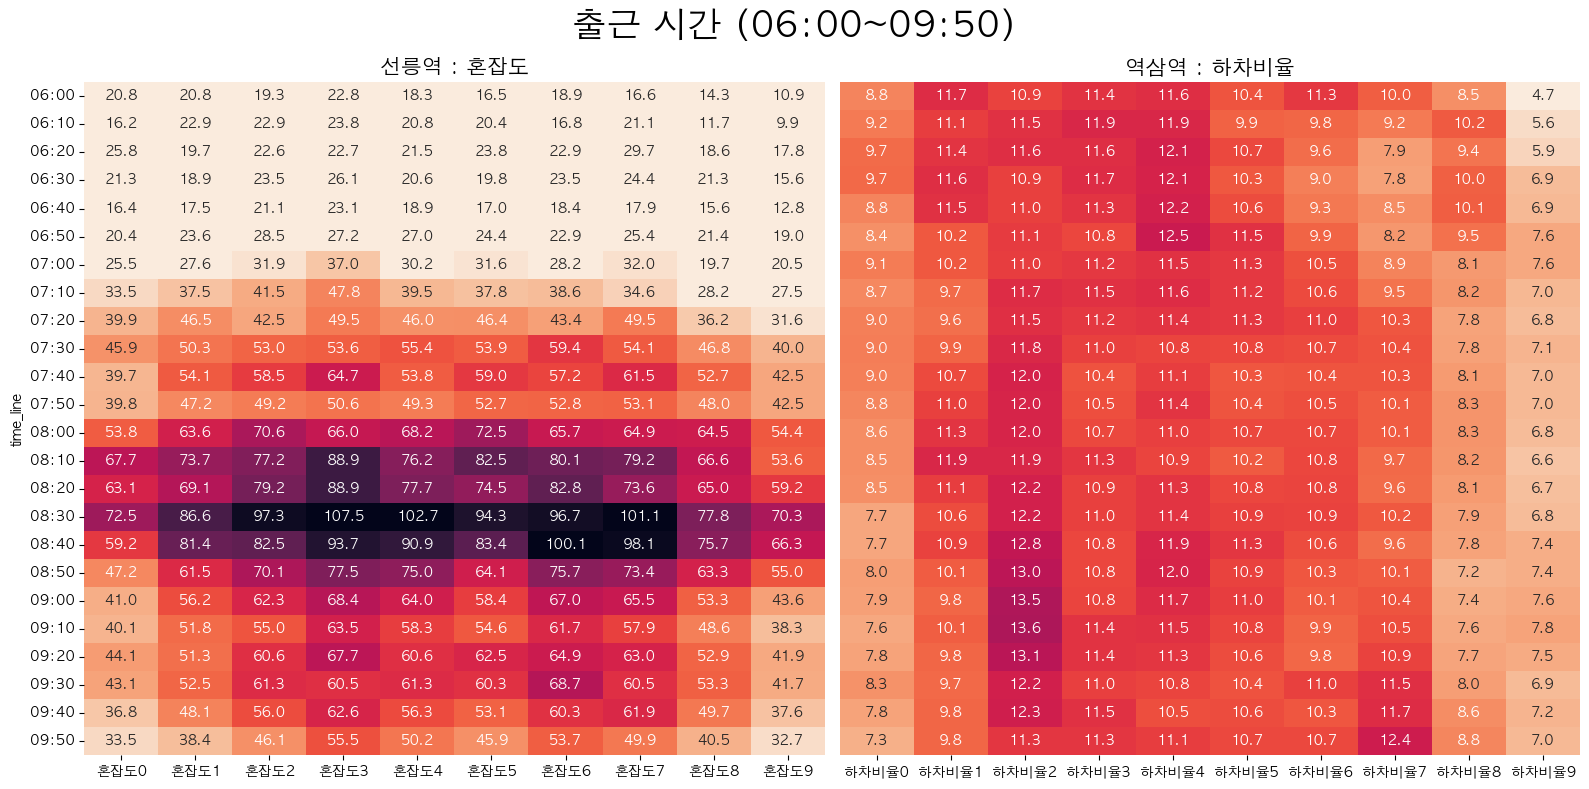

In [176]:
# 출근 시간 (06:00~09:50)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.heatmap(data=df_2[df_2['time_line'].str.startswith('0')].groupby('time_line')[[i for i in df_2.columns if i.startswith('혼잡도')]].mean(),
            cmap='rocket_r',
            annot=True,
            fmt='.1f',
            vmin=30,
            vmax=100,
            cbar=False
            )
plt.title(df_2['stationName'].unique()[0]+' : 혼잡도',fontsize=15)
plt.tight_layout()
plt.subplot(1,2,2)
sns.heatmap(data=df_3_next[df_3_next['time_line'].str.startswith('0')].groupby('time_line')[[i for i in df_3_next.columns if i.startswith('하차비율')]].mean(),
            cmap='rocket_r',
            annot=True,
            fmt='.1f',
            cbar=False,
            vmin=50/len([i for i in df_3_next.columns if i.startswith('하차비율')]),
            vmax=200/len([i for i in df_3_next.columns if i.startswith('하차비율')])
            )
plt.title(df_3_next['stationName'].unique()[0]+' : 하차비율',fontsize=15)
plt.yticks([])
plt.ylabel('')
plt.suptitle("출근 시간 (06:00~09:50)", fontsize=25)
plt.tight_layout()
plt.show()

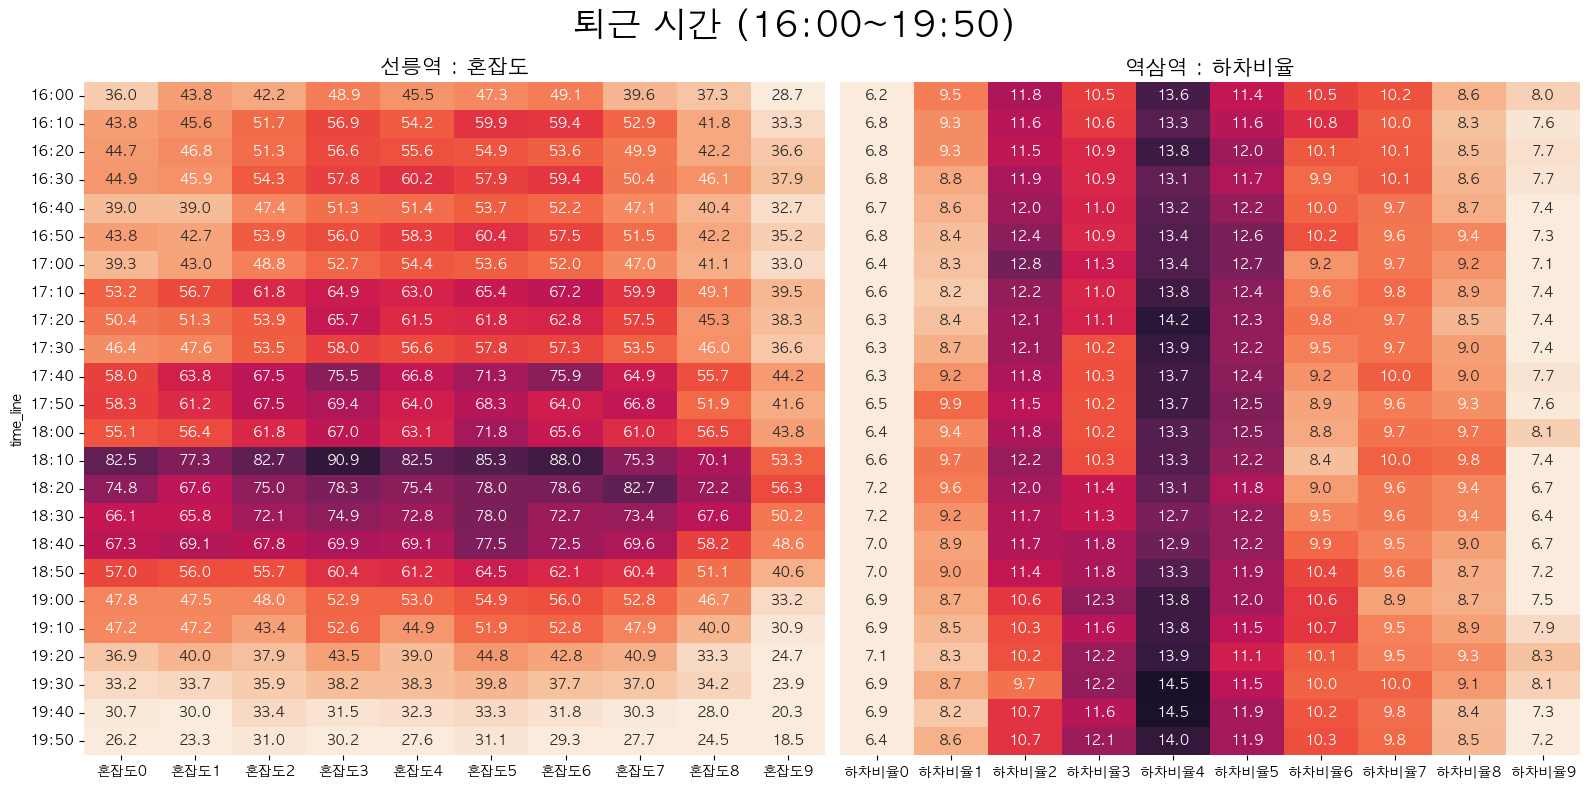

In [177]:
# 퇴근 시간 (16:00~19:50)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.heatmap(data=df_2[df_2['time_line'].str.startswith('1')].groupby('time_line')[[i for i in df_2.columns if i.startswith('혼잡도')]].mean(),
            cmap='rocket_r',
            annot=True,
            fmt='.1f',
            vmin=30,
            vmax=100,
            cbar=False
            )
plt.title(df_2['stationName'].unique()[0]+' : 혼잡도',fontsize=15)
plt.tight_layout()
plt.subplot(1,2,2)
sns.heatmap(data=df_3_next[df_3_next['time_line'].str.startswith('1')].groupby('time_line')[[i for i in df_3_next.columns if i.startswith('하차비율')]].mean(),
            cmap='rocket_r',
            annot=True,
            fmt='.1f',
            cbar=False,
            vmin=75/len([i for i in df_3_next.columns if i.startswith('하차비율')]),
            vmax=150/len([i for i in df_3_next.columns if i.startswith('하차비율')])
            )
plt.title(df_3_next['stationName'].unique()[0]+' : 하차비율',fontsize=15)
plt.yticks([])
plt.ylabel('')
plt.suptitle("퇴근 시간 (16:00~19:50)", fontsize=25)
plt.tight_layout()
plt.show()